# Pipelines

* A fixed sequence of steps in processing the data, for example feature selection, normalization and classification

* Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply, in sequencial order.

* Scikit-Learn provides the Pipeline class to help with such sequences of transformations. 

* Let's revisit the Exploratory Data Analysis and apply data preparation steps in a pipeline


In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline, FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import jedi
import nbextensions

import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set(rc={"figure.figsize": (12, 8)})
%load_ext line_profiler
from sklearn.utils import resample

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [62]:
# Load the data
df = pd.read_csv('http://www.chalendony.de/application_train.csv')

In [63]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# Remove the identifier column
df.drop(['SK_ID_CURR'], inplace=True, axis=1)

## Assign data types for  numerical and categorical attributes

In [65]:
categorical_features = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE', \
                        'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','FLAG_MOBIL','FLAG_EMP_PHONE',\
                        'FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL','OCCUPATION_TYPE','CNT_FAM_MEMBERS',\
                        'REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY','WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START',\
                        'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION','REG_CITY_NOT_LIVE_CITY',\
                        'REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','ORGANIZATION_TYPE','FLAG_DOCUMENT_2','FLAG_DOCUMENT_3',\
                        'FLAG_DOCUMENT_4','FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_7','FLAG_DOCUMENT_8','FLAG_DOCUMENT_9',\
                        'FLAG_DOCUMENT_10','FLAG_DOCUMENT_11','FLAG_DOCUMENT_12','FLAG_DOCUMENT_13','FLAG_DOCUMENT_14','FLAG_DOCUMENT_15',\
                        'FLAG_DOCUMENT_16','FLAG_DOCUMENT_17','FLAG_DOCUMENT_18','FLAG_DOCUMENT_19','FLAG_DOCUMENT_20','FLAG_DOCUMENT_21',\
                        'EMERGENCYSTATE_MODE', 'FONDKAPREMONT_MODE','HOUSETYPE_MODE','WALLSMATERIAL_MODE']

numerical_features = df.columns.difference(categorical_features).values.tolist()

print('categorical({}) '.format(len(categorical_features)))
print('numeric({})'.format(len(numerical_features)))

categorical(52) 
numeric(69)


In [66]:
# Numerical column types are defaulted to floats
df[numerical_features] = df[numerical_features].astype("float")
df['TARGET'] = df['TARGET'].astype("float")

# Categorical features can't be set all at once
for f in categorical_features:
    df[f] = df[f].astype("category")

    
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: category(52), float64(69)
memory usage: 177.1 MB


## Create train and test sets : DROP THE STATIFIED EXAMPLE - use all minority and sample majority - take different samples from the majority class

In [67]:
# Partition data set into training/test using Stratefied split to maintain distribution - does this make sense when we downsample????????
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df,df["TARGET"]):
    X_train = df.loc[train_index]
    X_test = df.loc[test_index]
    

In [84]:
## are there nan in the target
X_train

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
127014,0.0,Cash loans,F,N,N,0.0,157500.0,1534500.0,42196.5,1534500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
46214,0.0,Cash loans,F,N,N,0.0,90000.0,265851.0,21442.5,229500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
153845,0.0,Cash loans,M,N,Y,0.0,135000.0,254700.0,14751.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0
70434,0.0,Cash loans,F,N,Y,2.0,180000.0,254700.0,27153.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,1.0
102367,0.0,Cash loans,F,N,N,0.0,166500.0,900000.0,38263.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
302719,0.0,Cash loans,F,Y,Y,0.0,202500.0,1046142.0,30717.0,913500.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
51874,0.0,Cash loans,F,N,Y,0.0,90000.0,127350.0,12726.0,112500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
134163,0.0,Cash loans,F,N,Y,0.0,135000.0,927000.0,27234.0,927000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,7.0
216434,0.0,Cash loans,F,Y,N,2.0,163350.0,1309158.0,47151.0,1156500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
110409,0.0,Cash loans,F,N,Y,1.0,67500.0,312840.0,24844.5,247500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0


In [85]:
## downsample majority class
df_majority = X_train[X_train.TARGET==0]
df_minority = X_train[X_train.TARGET==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(df_minority),     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
X_train = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
X_train.TARGET.value_counts()

train_index

1.0    19860
0.0    19860
Name: TARGET, dtype: int64

In [101]:
## get index of the new sample

pd.DataFrame(X_train.loc[train_index].TARGET)

,TARGET
154241,0.0
14148,0.0
173633,0.0
164511,0.0
110175,0.0
262006,0.0
122639,0.0
249681,0.0
201604,0.0
283460,0.0


In [104]:
# pop target from the training and test sets
train_index = X_train.index
y_train = pd.DataFrame(X_train.loc[train_index].TARGET)
y_test = X_test.TARGET[test_index]

print(y_train.shape)
print(y_test.shape)
X_train.drop('TARGET', inplace=True, axis=1)
X_test.drop('TARGET', inplace=True, axis=1)

(39720, 1)
(61503,)


In [118]:
y_test.values

array([0., 0., 0., ..., 0., 1., 0.])

## Pipeline with FeatureUnion
* NOTE: OneHotEncoder in Scikit-Learn 0.19 can only handle integer categorical inputs
* import it from future_encoders.py supplied from: https://github.com/ageron/handson-ml/blob/master/future_encoders.py. 
* When Scikit-Learn 0.20 is released, you can import it from sklearn.preprocessing instead.

In [105]:
# Pipeline classes
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [106]:
x_cols = [*X_train.columns.values]

In [122]:
# We can still get our column name from the OneHotEncoder object through its get_feature_names method.
preprocess_pipeline = make_pipeline(
    ColumnSelector(columns=x_cols),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.float64),
            SimpleImputer(strategy="median", verbose=1),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            SimpleImputer(strategy="most_frequent", verbose=1),
            OneHotEncoder(sparse=False, handle_unknown='ignore')
        ))
    ])
)

In [123]:
classifier_pipeline = make_pipeline(
    preprocess_pipeline,
    #SGDClassifier(loss="hinge", penalty="l2", max_iter=5)
    SVC(gamma = 'auto', kernel="rbf", random_state=42)
)


param_grid = {
    "svc__gamma": ['auto'], "svc__kernel": ['rbf'] 

}


In [110]:
%%timeit -n 1 -r 1 -t x = range(10)
model = classifier_pipeline.fit(X_train, y_train.values.ravel())

/Users/stewarta/anaconda3/envs/wrangle_env/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


9min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


29min 59s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


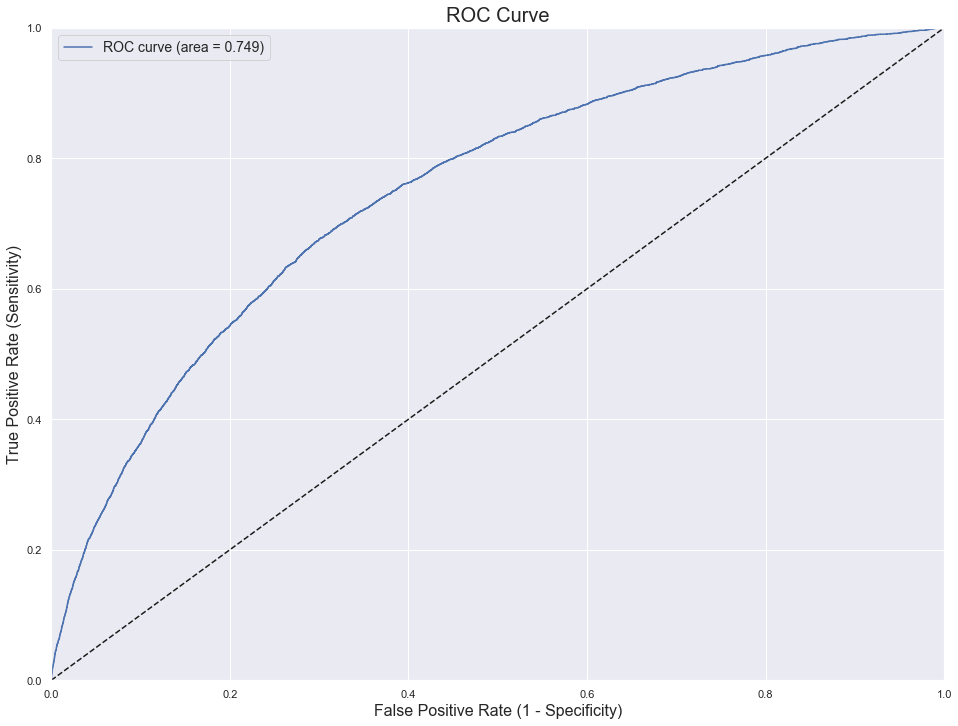

In [124]:
%%timeit -n 1 -r 1 -t x = range(10)
classifier_model = GridSearchCV(classifier_pipeline, param_grid, cv=2)
classifier_model.fit(X_train, y_train.values.ravel())

y_score = classifier_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test.values, y_score)
roc_auc = roc_auc_score(y_test.values, y_score)

# Plot ROC curve
plt.figure(figsize=(16, 12))
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)', size=16)
plt.ylabel('True Positive Rate (Sensitivity)', size=16)
plt.title('ROC Curve', size=20)
plt.legend(fontsize=14);

In [ ]:
## column transformer alternative to the Feature Union

In [ ]:
# Binning and encoding numeric columns with the new KBinsDiscretizer
https://medium.com/dunder-data/from-pandas-to-scikit-learn-a-new-exciting-workflow-e88e2271ef62

In [ ]:
## revisit the problem of training a larger data set - upsample
https://elitedatascience.com/imbalanced-classes